Example notebook on how to use our data and correctly apply the scaler

# Load data from disck

In [1]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging
from tensorflow import keras
import visualkeras
from datetime import datetime
from random import shuffle
import pickle

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
import os
import random
import numpy as np 
import tensorflow as tf

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0


In [2]:
BATCH_SIZE = 64
DROPOUT = 0
REGULARIZATION = False
PATIENCE = 10

In [3]:
# load plain data split
with open("./train_test_obj", "rb") as f:
  x_train, x_test, y_train, y_test = pickle.load(f)

In [4]:
# load scaler
with open("./scaler.p", "rb") as f:
    scaler = pickle.load(f)

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Utils Functions

In [5]:
def from_raw_to_dataframe(x_raw, y_raw):
    tabular_list = []
    for i_sample, x in enumerate(x_raw):
        for i_time, xx in enumerate(x):
            tabular_list.append([i_sample, i_time] + list(xx) + [y_raw[i_sample]])
    df_res = pd.DataFrame(tabular_list).rename(columns={
        0: 'sample_id',
        1: 'time',
        2: 'feat_1',
        3: 'feat_2',
        4: 'feat_3',
        5: 'feat_4',
        6: 'feat_5',
        7: 'feat_6',
        8: 'label'}, inplace=False, errors='raise')
    return df_res

In [6]:
def build_sequences(df):
    # Sanity check to avoid runtime errors
    #assert window % stride == 0
    dataset = []
    labels = []
    for id in df['sample_id'].unique():
        # Take only meaningful features
        temp = df[df['sample_id'] == id][['feat_1','feat_2','feat_3','feat_4','feat_5','feat_6']].values
        # Save the label
        label = df[df['sample_id'] == id]['label'].values[0]
        labels.append(label)
        dataset.append(temp)

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [7]:
def normalize_data_feature_wise(x_original, y_original, max_value=1, quantile=False):
    x_original_tabular = from_raw_to_dataframe(x_original, y_original)
    if quantile:
        scaler = RobustScaler()
    else:
        scaler = MinMaxScaler(feature_range=(0, max_value))
    scaler.fit_transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
    x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(
        x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])

    agg_x, agg_y = build_sequences(x_original_tabular)
    return agg_x, agg_y, scaler

In [8]:
def apply_scaler_to_new_data(x,y,scaler):
  x_original_tabular = from_raw_to_dataframe(x, y)
  x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
  agg_x, agg_y = build_sequences(x_original_tabular)
  return agg_x, agg_y

# Data processing

In [9]:
x_train_norm, y_train_norm = apply_scaler_to_new_data(x_train, y_train, scaler)
x_test_norm, y_test_norm = apply_scaler_to_new_data(x_test, y_test, scaler)

#train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm)).batch(BATCH_SIZE)
#test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm)).batch(BATCH_SIZE)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-23 16:45:30.350705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 16:45:30.350802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Weights

In [10]:
# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight
NUM_CLASSES = 12
def get_class_weight(y):
    total_samples = len(y)
    class_weight = {}
    for i in range(NUM_CLASSES):
        class_weight[i] = 1 - (np.bincount(y)[i] / total_samples)
    return class_weight

#class_weight = get_class_weight(y_train_norm)
#class_weight

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train_norm),
                                        y = y_train_norm                                                    
                                    )
class_weight = dict(zip(np.unique(y_train_norm), class_weights))
#class_weight

# Model Usage

## 1DConv

In [12]:
def Conv1D_BN_ReLu_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.GlobalAveragePooling1D()(x)

    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## LSTM

In [13]:
def build_LSTM_classifier_BASE(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer) #Number of neurons means dimension of the cell
    lstm = tfkl.LSTM(32)(lstm)
    
    dropout = tfkl.Dropout(DROPOUT, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    model.summary()
    # Return the model
    return model

In [14]:
def build_LSTM_classifier_MIDDLE(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer) #Number of neurons means dimension of the cell
    lstm = tfkl.LSTM(32, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(32)(lstm)
    
    #lstm = tfkl.LSTM(32)(lstm) # MIDDLE
    #lstm = tfkl.LSTM(32)(lstm) # BIG
    dropout = tfkl.Dropout(DROPOUT, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    model.summary()
    # Return the model
    return model

In [15]:
def build_LSTM_classifier_BIG(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer) #Number of neurons means dimension of the cell
    lstm = tfkl.LSTM(32, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(32, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(32)(lstm)
    
    #lstm = tfkl.LSTM(32)(lstm) # MIDDLE
    #lstm = tfkl.LSTM(32)(lstm) # BIG
    dropout = tfkl.Dropout(DROPOUT, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    model.summary()
    # Return the model
    return model

## Bidrectional LSTM

In [16]:
from tensorflow.keras import regularizers

def bidirectional_LSTM(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(input_layer)
    #x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(x)# MIDDLE LSTM
    #x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(x)# BIGTM
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(x) 
    if REGULARIZATION:
        x = keras.layers.Dense(32, kernel_regularizer=regularizers.l2(REGULARIZING_FACTOR), activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## CNN from Lab

In [17]:
def CC_from_Lab_BASE(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [18]:
def CC_from_Lab_MIDDLE(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    
    # MIDDLE
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [19]:
def CC_from_Lab_BIG(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    
    # MIDDLE
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    # BIG 
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

# Choose Model

In [20]:
model = bidirectional_LSTM((x_train.shape[1], x_train.shape[2]))
#model = CC_from_Lab((x_train_norm.shape[1], x_train_norm.shape[2]))
#model = Conv1D_BN_ReLu_model((x_train_norm.shape[1], x_train_norm.shape[2]))

# LSTM
#model = build_LSTM_classifier_BASE((x_train_norm.shape[1], x_train_norm.shape[2]), NUM_CLASSES)
#model = build_LSTM_classifier_MIDDLE((x_train_norm.shape[1], x_train_norm.shape[2]), NUM_CLASSES)
#model = build_LSTM_classifier_BIG((x_train_norm.shape[1], x_train_norm.shape[2]), NUM_CLASSES)

# BDLSTM
#model = bidirectional_LSTM((x_train.shape[1], x_train.shape[2]))
#model = tf.keras.models.load_model('../SavedModels/BILSTM_07325Fullbi') # Gianmario's best model
#print(model.layers[2].rate)
#print(model.layers[4].rate)
#config = model.get_config()
#model = tf.keras.Model.from_config(config)


In [21]:
"""
print(model.layers[2].rate)
print(model.layers[4].rate)
model.layers[2].rate = 0.5
model.layers[4].rate = 0.5
print(model.layers[2].rate)
print(model.layers[4].rate)
"""

'\nprint(model.layers[2].rate)\nprint(model.layers[4].rate)\nmodel.layers[2].rate = 0.5\nmodel.layers[4].rate = 0.5\nprint(model.layers[2].rate)\nprint(model.layers[4].rate)\n'

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 64)           9984      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [23]:
callbacks = [
        keras.callbacks.EarlyStopping(
            #monitor="val_loss", 
            monitor="val_sparse_categorical_accuracy",
            patience = PATIENCE, 
            verbose=1,
            restore_best_weights=True
        ),
    ]

model.compile(
    optimizer= keras.optimizers.Adam(),
    #loss="sparse_categorical_crossentropy",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    train_dataset,
    epochs=500,
    callbacks=callbacks,
    validation_data= test_dataset,
    verbose=1,
    class_weight=class_weight,
)

Epoch 1/500


2022-12-23 16:45:31.391976: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-23 16:45:33.646445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:33.966619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:33.981845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:34.126028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:34.141194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:34.349199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

31/31 [==============================] - ETA: 0s - loss: 2.4417 - sparse_categorical_accuracy: 0.2007

2022-12-23 16:45:37.230492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:37.357274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:37.367464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:37.483383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:37.494283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 7s 106ms/step - loss: 2.4417 - sparse_categorical_accuracy: 0.2007 - val_loss: 2.2985 - val_sparse_categorical_accuracy: 0.2634
Epoch 2/500
31/31 [==============================] - 2s 57ms/step - loss: 2.2283 - sparse_categorical_accuracy: 0.3042 - val_loss: 2.0882 - val_sparse_categorical_accuracy: 0.3107
Epoch 3/500
31/31 [==============================] - 2s 57ms/step - loss: 1.8921 - sparse_categorical_accuracy: 0.2697 - val_loss: 1.9569 - val_sparse_categorical_accuracy: 0.1811
Epoch 4/500
31/31 [==============================] - 2s 68ms/step - loss: 1.6361 - sparse_categorical_accuracy: 0.2512 - val_loss: 1.8930 - val_sparse_categorical_accuracy: 0.1975
Epoch 5/500
31/31 [==============================] - 2s 68ms/step - loss: 1.4670 - sparse_categorical_accuracy: 0.2908 - val_loss: 1.8151 - val_sparse_categorical_accuracy: 0.2202
Epoch 6/500
31/31 [==============================] - 2s 64ms/step - loss: 1.3218 - sparse_categorical_accuracy:

In [24]:
#model = keras.models.load_model("./Fully_Convolutional_Neural_Network/")
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print("\n")
print("Test accuracy", test_acc)
print("Test loss", test_loss)

8/8 - 0s - loss: 2.0882 - sparse_categorical_accuracy: 0.3107 - 257ms/epoch - 32ms/step


Test accuracy 0.31069958209991455
Test loss 2.08817195892334


In [25]:
# Predict the test set 
predictions = model.predict(test_dataset)

2022-12-23 16:45:59.764486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:59.873515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:45:59.884761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/8 [==========>...................] - ETA: 0s

2022-12-23 16:46:00.004459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:46:00.015893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 50ms/step


In [26]:
import sklearn
from sklearn.metrics import confusion_matrix
f1_score = sklearn.metrics.f1_score(y_test, predictions.argmax(axis=1), average='macro')
print("F1 score", f1_score)

F1 score 0.20155633277358756


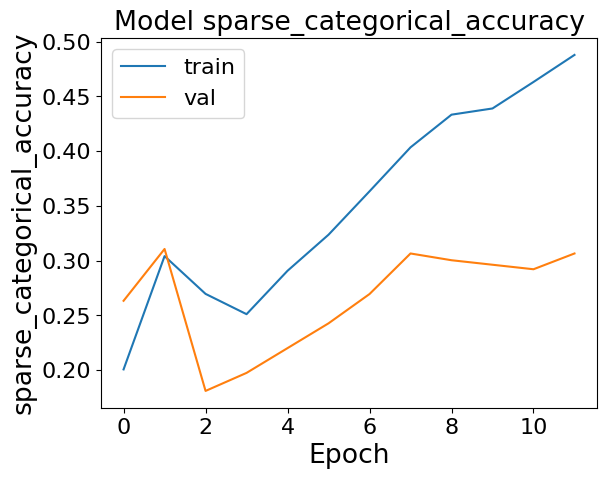

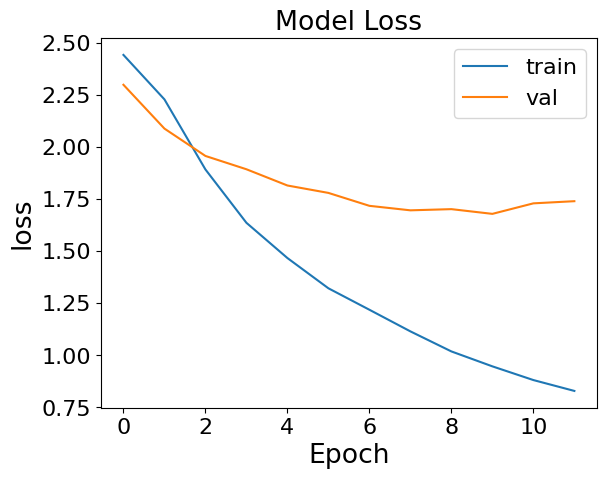

In [27]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# Plot the loss function
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

In [28]:
Classes = ["Wish", "Another", "Comfortably", "Money", "Breathe", "Time", "Brain", "Echoes", "Wearing", "Sorrow", "Hey", "Shine"]

Normalized confusion matrix
[[0.         0.25       0.         0.         0.         0.
  0.         0.         0.25       0.         0.         0.5       ]
 [0.18181818 0.18181818 0.         0.04545455 0.         0.31818182
  0.04545455 0.09090909 0.04545455 0.09090909 0.         0.        ]
 [0.04444444 0.06666667 0.64444444 0.         0.         0.02222222
  0.         0.02222222 0.13333333 0.04444444 0.         0.02222222]
 [0.02409639 0.01204819 0.02409639 0.02409639 0.         0.09638554
  0.         0.13253012 0.         0.56626506 0.         0.12048193]
 [0.07692308 0.         0.         0.         0.         0.07692308
  0.         0.07692308 0.         0.46153846 0.         0.30769231]
 [0.03125    0.125      0.         0.         0.         0.21875
  0.         0.125      0.         0.4375     0.         0.0625    ]
 [0.01449275 0.14492754 0.04347826 0.02898551 0.         0.11594203
  0.02898551 0.13043478 0.1884058  0.28985507 0.         0.01449275]
 [0.         0.125      

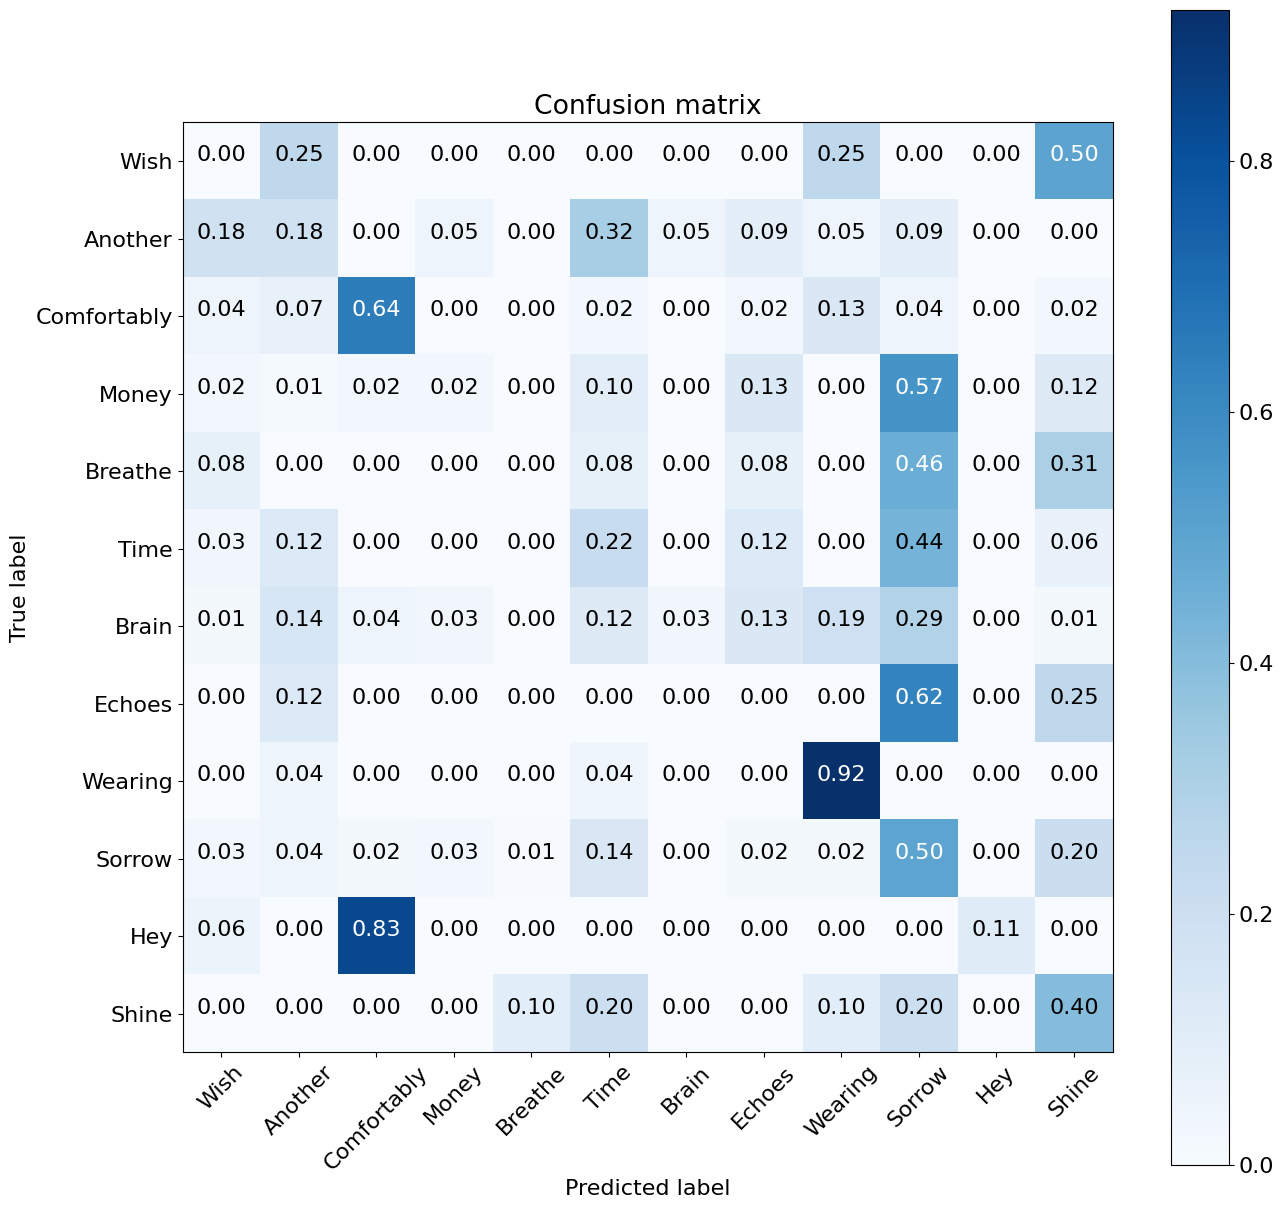

In [29]:
# Funtion that plots the confusion matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(confusion_matrix(y_test, predictions.argmax(axis=1)), classes=Classes, normalize=True) 

In [32]:
SAFE_MODEL = True
SAFE_HISTORY = True

MODELNAME = "BaseModel_WithScaler_BDLSTM"

# Save model
if SAFE_MODEL:
    model.save('SavedModelsForPlotting/' + MODELNAME)
    print("Model saved")

import pickle
if SAFE_HISTORY:
    print("Saving history")
    # Save the history of the model as a pickle file
    with open('SavedModelsForPlotting/' +  MODELNAME + '/history.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    print("History saved")
# Load the history of the model
#with open('SavedModels/LSTM_history.pickle', 'rb') as file_pi:
#    history = pickle.load(file_pi)

INFO:tensorflow:Assets written to: SavedModelsForPlotting/BaseModel_WithScaler_BDLSTM/assets


INFO:tensorflow:Assets written to: SavedModelsForPlotting/BaseModel_WithScaler_BDLSTM/assets


Model saved
Saving history
History saved
